## MNIST: Train Convolutional Neural Network using Tensorflow 

**Dataset:** 
- MNIST Dataset
- http://yann.lecun.com/exdb/mnist/

In [94]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
import tqdm
# Get Data From Tensorflow Tutorial and save copy to local directory
from tensorflow.examples.tutorials.mnist import input_data

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
Original Training Shape: (55000, 784)
Original Validation Shape: (5000, 784)
Original Testing Shape: (55000, 784)
Reformat to 28x28 Pixels Shape: (55000, 28, 28)


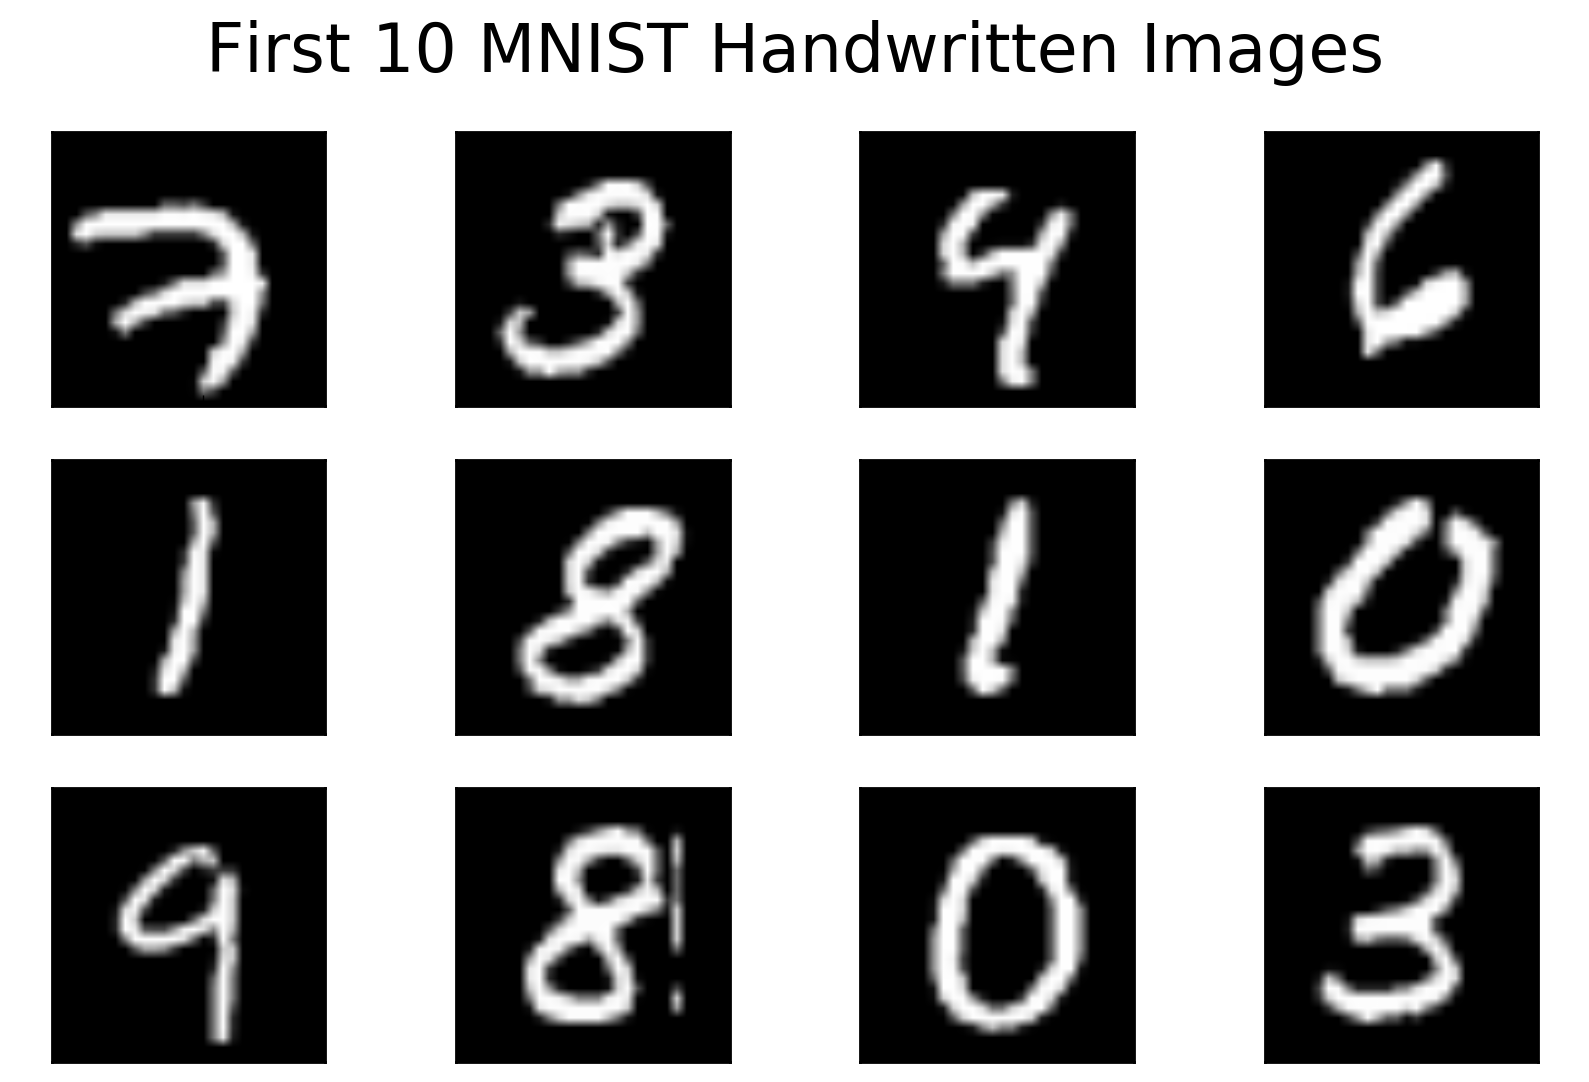

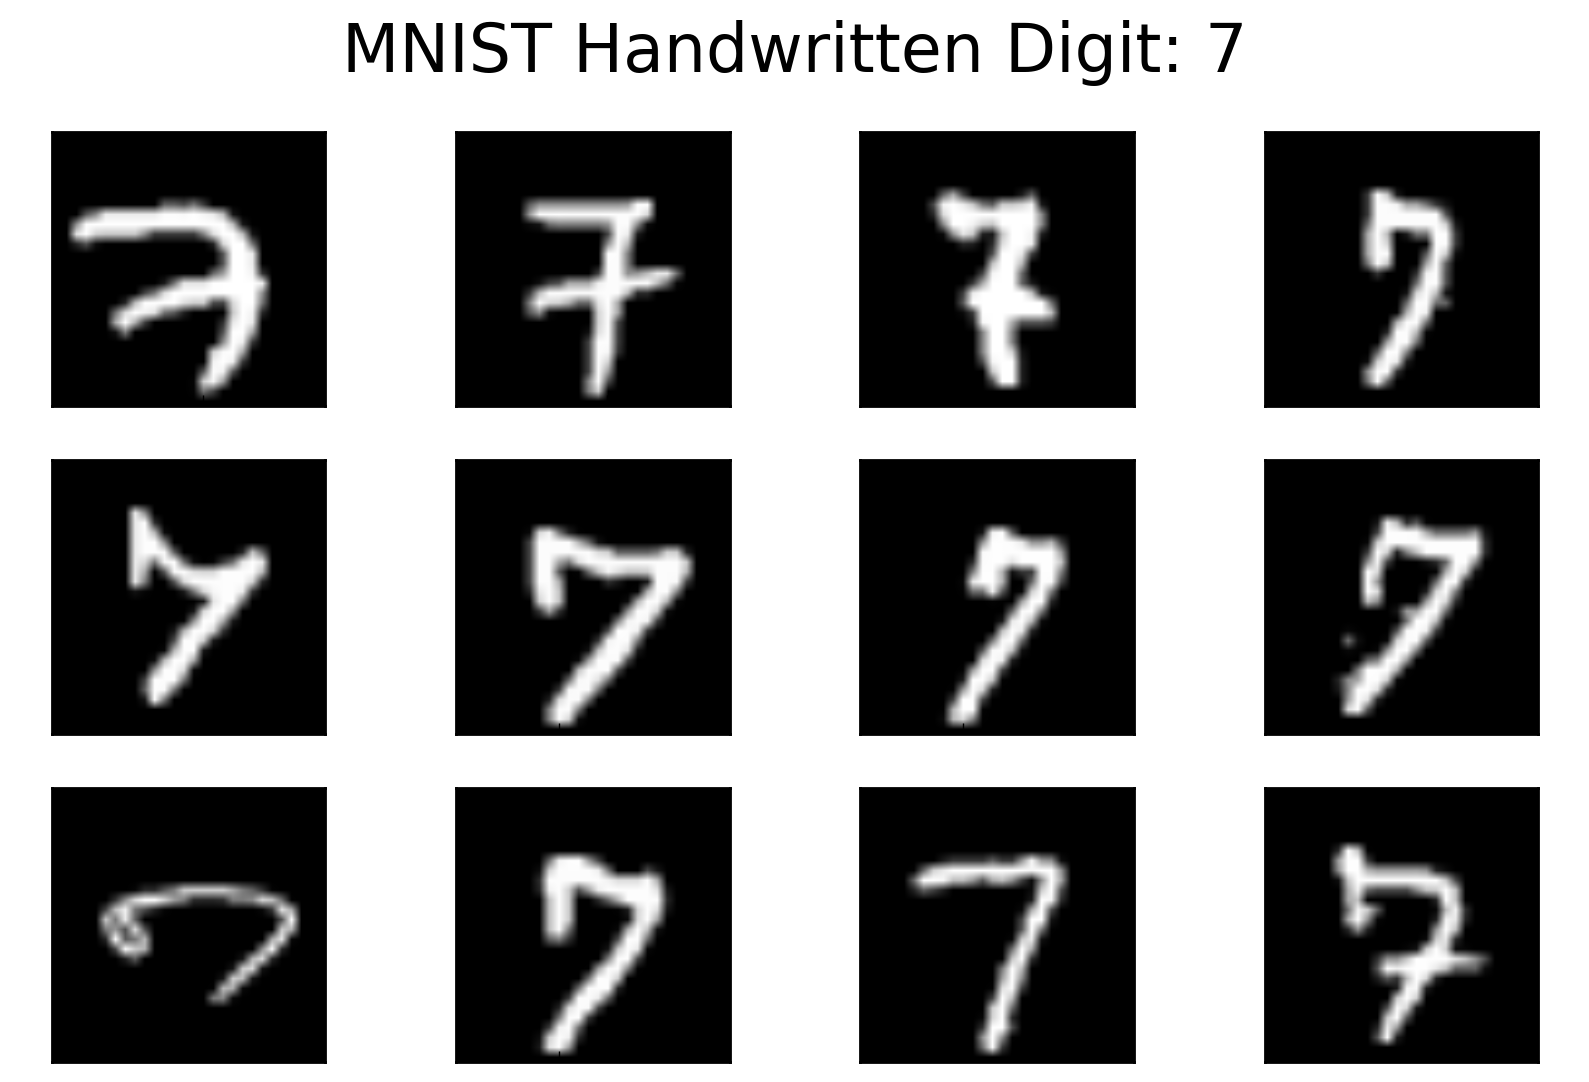

In [95]:
def process_data(mnist):
    
    """
    Return preprocessed Training/Testing subsets of the MNIST Images
    
    Keyword arguments:
    None
    """
    
    X_train = mnist.train.images
    X_val = mnist.validation.images
    X_test = mnist.test.images
    print('Original Training Shape:',X_train.shape)
    print('Original Validation Shape:',X_val.shape)
    print('Original Testing Shape:',X_train.shape)

    
    # Training/Testing Labels
    y_train,y_val,y_test = mnist.train.labels,mnist.validation.labels,mnist.test.labels
    
    # Reshape Data into 28x28 pixels
    X_train_reshape = X_train.reshape(X_train.shape[0],28,28)
    X_test_reshape = X_test.reshape(X_test.shape[0],28,28)
    
    print('Reformat to 28x28 Pixels Shape:',X_train_reshape.shape)
    return(X_train,X_val,X_test,y_train,y_val,y_test,X_train_reshape,X_test_reshape)

def explore_images(X,images=10):
    n_col = 4
    n_row = int(np.ceil(images/n_col))
    
    fig = plt.figure(figsize=(2.5*n_col,2.0*n_row))
    plt.title('First %.0f MNIST Handwritten Images' % images, fontsize=24,y=1.05)
    plt.box(False)
    plt.xticks(())
    plt.yticks(())
    for img,i in enumerate(range(n_row*n_col)):
        ax = fig.add_subplot(n_row,n_col,i+1)
        ax.imshow(X[img],cmap='gray',interpolation=None)
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        
def explore_specific_digits(X,y,digit,images=10):
                            
    X = X[np.argmax(y,axis=1) == digit]
    
    n_col = 4
    n_row = int(np.ceil(images/n_col))
    
    fig = plt.figure(figsize=(2.5*n_col,2.0*n_row))
    plt.title('MNIST Handwritten Digit: %s' % digit, fontsize=24,y=1.05)
    plt.box(False)
    plt.xticks(())
    plt.yticks(())
    for img,i in enumerate(range(n_row*n_col)):
        ax = fig.add_subplot(n_row,n_col,i+1)
        ax.imshow(X[img],cmap='gray',interpolation=None)
        ax.set_xticklabels('')
        ax.set_yticklabels('')

        
if __name__ == '__main__':
    
    #Load MNIST and store locally
    mnist = input_data.read_data_sets('data/MNIST_data',one_hot=True)
    
    #Prep Data
    X_train,X_val,X_test,y_train,y_val,y_test,X_train_reshape,X_test_reshape = process_data(mnist)
    
    #Explore Images
    explore_images(X_train_reshape)
    
    #Explore Specific Digits
    explore_specific_digits(X_train_reshape,y_train,7)

____
### ConvNet

In [115]:
class Convolutional_Nerual_Network():
    
    def __init__(self,params,batch_norm=False):
        
        # Argument to use toggle between implementing batch norm 
        self.batch_norm = batch_norm
        self.name = "Batch Normalization" if batch_norm else "Without Batch Normalization"

        # Batch normalization needs to do different calculations during training
        self.is_training = tf.placeholder(tf.bool, name= "is_training")

        # Store Accuracies
        self.training_accuracies = []
        self.testing_accuracies = []

        # Initialize Build
        self.build_network(**params)

    def conv2d_maxpool(self,X,filters,conv_ksize,conv_strides,pool_ksize,pool_strides):
        
        # Convolutional Layer
        conv = tf.layers.conv2d(X,filters,conv_ksize,conv_strides,padding='SAME',activation=tf.nn.relu) 
        max_pool = tf.layers.max_pooling2d(conv,pool_ksize,pool_strides,padding='SAME')
        return max_pool
    
    def build_network(self,**params):

        # Reshape Tensor
        self.input = tf.placeholder(tf.float32, shape=[None,params['height'],params['width'],params['n_channels']])
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob') 
        
        # 1st Convolutional Layer
        conv2d_maxpool_layer_1 = self.conv2d_maxpool(self.input,params['filters_1'],
                                        params['conv_ksize'], params['conv_strides'],
                                        params['pool_ksize'], params['pool_strides'])

        # 2nd Convolutional Layer
        conv2d_maxpool_layer_2 = self.conv2d_maxpool(conv2d_maxpool_layer_1, params['filters_2'],
                                        params['conv_ksize'], params['conv_strides'],
                                        params['pool_ksize'], params['pool_strides'])
        
        # 3rd Convolutional Layer
        conv2d_maxpool_layer_3 = self.conv2d_maxpool(conv2d_maxpool_layer_2, params['filters_3'],
                                        params['conv_ksize'], params['conv_strides'],
                                        params['pool_ksize'], params['pool_strides'])
        
        # Fully Connected Layer
        flatten = tf.nn.dropout(tf.contrib.layers.flatten(conv2d_maxpool_layer_3),self.keep_prob)
        
        # Output Layer
        self.output_layer = tf.layers.dense(flatten, params['output_dim'])

        
    def train(self,X_train,X_val,y_train,y_val,session,learning_rate,batches,batches_per_sample,output_dim):
    
        # Target Labels
        labels = tf.placeholder(tf.float32,shape=[None,output_dim],name='labels')
    
        # Loss Function
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=self.output_layer))
                    
        # Define operations for testing validation set
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # Train
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

        # Train model for the specified number of batches
        for i in tqdm.tqdm(range(batches)):
            
            # Random Mini-Batch Sample --> Training Set
            batch_x_train, batch_y_train = get_random_sample(X_train,y_train,batches_per_sample)
            batch_x_val, batch_y_val = get_random_sample(X_val,y_val,batches_per_sample)

            # Compute Loss on Training Set
            session.run(train_step,feed_dict={self.input: batch_x_train, 
                                             labels: batch_y_train,
                                             self.keep_prob: 0.50,self.is_training: False})
            
            # Periodically Get Accuracy Score for Random Sample from Validation Set
            if i % batches_per_sample == 0:
                self.training_accuracies.append(session.run(accuracy,feed_dict={self.input: batch_x_val,
                                                            labels: batch_y_val,self.keep_prob:0.50,
                                                            self.is_training: False}))
                      
        val_accuracy = session.run(accuracy,feed_dict={self.input: X_val, labels: y_val,
                                                       self.keep_prob: 0.50,
                                                       self.is_training: False})
        
        print('='*65)
        print('Average Validation Set Accuracy {0} = {1:.3f}%'.format(self.name, val_accuracy*100))
        
    def test(self,X_test,y_test,session,output_dim):

        # Placeholder will store target labels for each mini batch
        labels = tf.placeholder(tf.float32,shape=[None,output_dim],name='labels')

        # Define operations for testing
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # Test against all test data
        self.testing_accuracies.append(session.run(accuracy, feed_dict={self.input: X_test,
                                                         labels: y_test,
                                                         self.keep_prob:0.50,
                                                         self.is_training: False}))

        print('Average Test Set Accuracy {0} = {1:.3f}%'.format(self.name, np.mean(self.testing_accuracies)*100))
    

In [125]:
def get_random_sample(X,y,batch_sample):
    
    # Random Mini-Batch Sample
    rand_idx = np.random.choice(len(X),size=batch_sample)
    batch_x,batch_y = X[rand_idx],y[rand_idx]
    return batch_x, batch_y

def plot_accuracies(*args,**kwargs):
    
    """ Plot Validation Accuracy"""
    
    sample_size = kwargs['batch_sample_size']

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    colors = ['teal','orange','blue','coral']
    for idx,arg in enumerate(args):
        ax.plot(range(0,len(arg.training_accuracies)*sample_size,sample_size),
            arg.training_accuracies,lw=2.0,color=colors[idx],label=arg.name)
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0,1)
        ax.set_xlabel('Number of Batches')
        ax.legend(frameon=False,loc=(1.01,0.50))
        ax.set_title('Validation Accuracy Score',y=1.02)
    plt.grid(True)

def get_nn_parameters(input_dim,pix_dim,n_channels,output_dim):

    params = {
            'input_dim':input_dim, # input dimensions
            'height': pix_dim[0],
            'width': pix_dim[1],
            'output_dim': output_dim, # output class labels
            'n_channels': n_channels, # number of dimensions
            'filters_1':18, # number of filters (i.e. n_channels for first layer)
            'filters_2':36, # number of filters (i.e. n_channels for second layer)
            'filters_3': 72, # number of filters (i.e. n_channels for third layer)
            'conv_ksize': (2,2), # kernal size for conv.layer
            'conv_strides': (2,2),
            'pool_ksize': 2, # kernal size for the conv. layer
            'pool_strides': 2 # stride for conv.
            }
    
#     params['conv_strides'] = params['conv_ksize'][0]/2, # stride for conv.
    params['conv_num_outputs'] = params['conv_ksize'][0] * params['conv_ksize'][0], # output dimension of conv. layer
    return params

def train_and_test(X_train,X_val,X_test,y_train,y_val,y_test,learning_rate,
                   n_batches,batch_size,*args):
    
    # Input Parameters
    params = get_nn_parameters(args[0],args[1],args[2],args[3])

    # Reset default graph if training two different models (i.e. with or w/out batch_norm)
    tf.reset_default_graph()

    # Create instance of Neural Network
    convnet = Convolutional_Nerual_Network(params)
    
    # Train Model
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
    
        # Training and Testing Model
        convnet.train(X_train,X_val,y_train,y_val,sess,learning_rate,n_batches,batch_size,params['output_dim'])
        convnet.test(X_test,y_test,sess,params['output_dim'])
    
#     # Plot Results
#     plot_accuracies(convnet,batch_sample_size=batch_sample_size)

**For images, input tensor shape is as follows: [Batch Size, Height, Width, Channel]**

In [126]:
r = X_train.reshape(-1,28,28,1)
r_val = X_val.reshape(-1,28,28,1)
r_test = X_test.reshape(-1,28,28,1)

In [128]:
if __name__ == '__main__':
    
    # Tune Parameters
    learning_rate = 0.01
    n_batches = 10000
    batch_sample_size = 250
    height_width = (28,28)
    
    n_classes = y_train.shape[1]
    %time results = train_and_test(r,r_val,r_test,y_train,y_val,\
                                  y_test,learning_rate,n_batches,batch_sample_size,\
                                  len(X_train),height_width,1,n_classes)

100%|██████████| 10000/10000 [04:04<00:00, 40.87it/s]


Average Validation Set Accuracy Without Batch Normalization = 85.940%
Average Test Set Accuracy Without Batch Normalization = 85.500%
CPU times: user 14min 40s, sys: 1min 25s, total: 16min 5s
Wall time: 4min 5s
